# V(D)J与基因表达整合分析 - 第二部分

## 在BEAM（条形码启用抗原映射）数据集中识别抗原反应性细胞

### 概述
本notebook模拟了**10x Genomics Loupe Browser V(D)J教程第二部分**中描述的功能。我们使用模拟BEAM数据来演示识别抗原反应性T细胞并在不同抗原特异性之间进行差异基因表达分析。

### 实现的功能

#### 🧪 **BEAM数据集模拟**
- 生成带有模拟抗原捕获数据的模拟人类T细胞数据集
- 创建真实的抗原反应性细胞分布：CMV（60%）、Flu（25%）、SARS-CoV-2（15%）
- 模拟具有高置信度阈值的抗原特异性评分

#### 🎯 **抗原特异性分析**
- 基于抗原特异性评分进行细胞筛选（阈值≥90）
- 识别SARS-CoV-2反应性细胞
- 识别Flu反应性细胞
- 为抗原特异性群体创建新的细胞类别

#### 📊 **差异基因表达**
- 比较Covid反应性与Flu反应性T细胞之间的基因表达
- 使用Wilcoxon秩和检验进行统计分析
- 识别在每个群体中显著上调的基因
- 可视化顶级差异表达基因

#### 🔬 **生物学洞察**
- 演示整合分析如何识别生物学相关基因
- 显示与不同抗原反应相关的潜在生物标记物
- 模拟类似于COVID反应性细胞中IL7R上调的发现

---

### 技术实现
- **BEAM模拟**：创建具有真实特异性评分分布的模拟抗原捕获数据
- **阈值筛选**：应用第90百分位数阈值以获得高置信度抗原反应性
- **统计分析**：采用scanpy的rank_genes_groups进行差异表达
- **可视化**：提供结果和基因排名的综合绘图

### 教程背景
本分析对应于Loupe Browser教程的**条形码启用抗原映射（BEAM）**部分，其中在基因表达聚类的背景下识别和分析对CMV、Flu和SARS-CoV-2抗原反应的T细胞。

**关键学习目标：**
- 理解抗原特异性评分和阈值设定
- 整合BEAM数据与基因表达分析
- 在抗原反应性群体之间进行比较分析
- 识别生物学相关的基因表达特征


## 1. 环境设置与增强数据模拟函数

我们首先导入库并定义增强的模拟数据生成函数。对于第二部分，我们专注于模拟BEAM（条形码启用抗原映射）数据，包含真实的抗原特异性评分和分布。


In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- 增强的模拟数据生成函数 ---
def generate_mock_data(part='I'):
    """
    生成具有增强BEAM模拟的真实模拟单细胞数据。
    
    参数:
    -----------
    part : str
        'I' 表示肺癌数据集，'II' 表示BEAM数据集
    
    返回:
    --------
    adata : AnnData
        包含基因表达和元数据的注释数据对象
    vdj_df : DataFrame
        V(D)J克隆型信息（第二部分包含抗原数据）
    """
    n_obs, n_vars, n_clusters, n_latent_dims = 3000, 500, 5, 15
    centers = np.random.rand(n_clusters, n_latent_dims) * 10
    X_latent, y_true = make_blobs(
        n_samples=n_obs, 
        n_features=n_latent_dims, 
        centers=centers, 
        cluster_std=2.0, 
        random_state=42
    )

    # 应用随机变换创建不规则、重叠聚类
    X_latent_transformed = np.zeros_like(X_latent)
    for i in range(n_clusters):
        cluster_indices = (y_true == i)
        cluster_points = X_latent[cluster_indices]
        mean_center = cluster_points.mean(axis=0)
        scaling_factors = np.random.uniform(0.5, 2.5, size=n_latent_dims)
        X_latent_transformed[cluster_indices] = (cluster_points - mean_center) * scaling_factors + mean_center
    
    # 生成基因表达矩阵
    X_latent = X_latent_transformed
    projection_matrix = np.random.normal(size=(n_latent_dims, n_vars))
    X = np.abs((X_latent @ projection_matrix) + np.random.normal(scale=0.8, size=(n_obs, n_vars)))

    # 创建AnnData对象
    barcodes = [f'BARCODE_{i}' for i in range(n_obs)]
    adata = sc.AnnData(
        X, 
        obs=pd.DataFrame(index=barcodes), 
        var=pd.DataFrame(index=[f'Gene_{j}' for j in range(n_vars)])
    )
    adata.obs['leiden_original'] = pd.Categorical(y_true)

    # 为部分细胞生成V(D)J数据
    vdj_barcodes = np.random.choice(barcodes, size=int(n_obs * 0.7), replace=False)
    vdj_data = []

    if part == 'II':
        # 第二部分：具有抗原特异性数据的BEAM数据集
        adata.obs['cell_type'] = 'T cells'
        
        # 基于教程模拟真实抗原分布
        # CMV: 40%, Flu: 10%, SARS-CoV-2: 5%（其余为非反应性）
        antigens = ['SARS_Cov2', 'Flu', 'CMV']
        
        for bc in vdj_barcodes:
            # 以真实概率分配抗原
            antigen = np.random.choice(antigens, p=[0.15, 0.25, 0.6])
            
            # 生成特异性评分
            # 大多数细胞具有低特异性（10-50）
            specificity = np.random.randint(10, 50)
            
            # 高特异性细胞（≥90）很少但存在于SARS-CoV-2和Flu中
            if antigen == 'SARS_Cov2' or antigen == 'Flu':
                # 这些抗原分配细胞中约20%具有高特异性
                if np.random.random() < 0.2:
                    specificity = np.random.randint(90, 101)
            
            vdj_data.append({
                'barcode': bc, 
                'clonotype_id': f'clonotype_{np.random.randint(1,100)}', 
                'antigen': antigen, 
                'antigen_specificity': specificity
            })

    vdj_df = pd.DataFrame(vdj_data)
    
    # 标准scanpy预处理流程
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=200)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.5, key_added='leiden')

    return adata, vdj_df

print("增强的模拟数据生成函数定义成功。")


增强的模拟数据生成函数定义成功。


## 2. 生成BEAM数据集并关联抗原信息

这一步模拟加载BEAM-T数据集并导入相应的V(D)J和抗原捕获数据。我们生成具有CMV、Flu和SARS-CoV-2模拟抗原特异性的T细胞群体。


第二部分：模拟BEAM-T数据集
细胞总数：3000
具有V(D)J/抗原数据的细胞：2100

抗原分布：
antigen
CMV          1242
NaN           900
Flu           541
SARS_Cov2     317
Name: count, dtype: int64


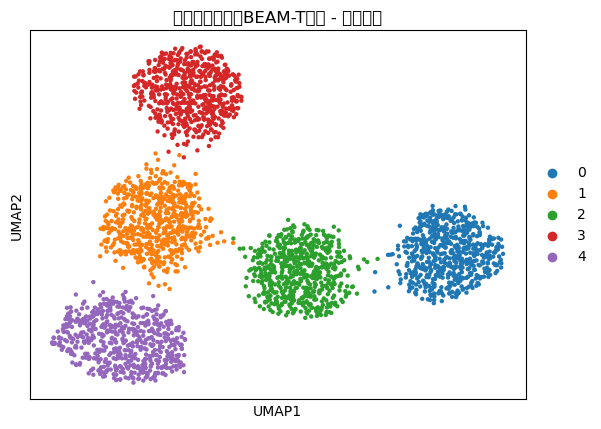

In [2]:
# 使用增强函数生成第二部分数据
adata_p2, vdj_df_p2 = generate_mock_data(part='II')

# 将抗原信息与基因表达数据关联
adata_p2.obs = adata_p2.obs.reset_index().merge(
    vdj_df_p2, left_on='index', right_on='barcode', how='left'
).set_index('index')

print("第二部分：模拟BEAM-T数据集")
print(f"细胞总数：{adata_p2.n_obs}")
print(f"具有V(D)J/抗原数据的细胞：{adata_p2.obs['antigen'].notna().sum()}")

print(f"\n抗原分布：")
print(adata_p2.obs['antigen'].value_counts(dropna=False))

sc.pl.umap(adata_p2, color='leiden', title='第二部分：模拟BEAM-T样本 - 初始聚类')


## 3. 筛选高抗原特异性细胞

本部分演示核心BEAM分析工作流程：基于抗原特异性评分筛选细胞以识别高置信度抗原反应性群体。我们应用90的阈值来识别具有强抗原反应性的细胞。


抗原特异性阈值：≥ 90
识别出的Covid反应性细胞：71
识别出的Flu反应性细胞：98

Covid反应性特异性评分：平均=94.9，范围=[90.0-100.0]
Flu反应性特异性评分：平均=95.1，范围=[90.0-100.0]


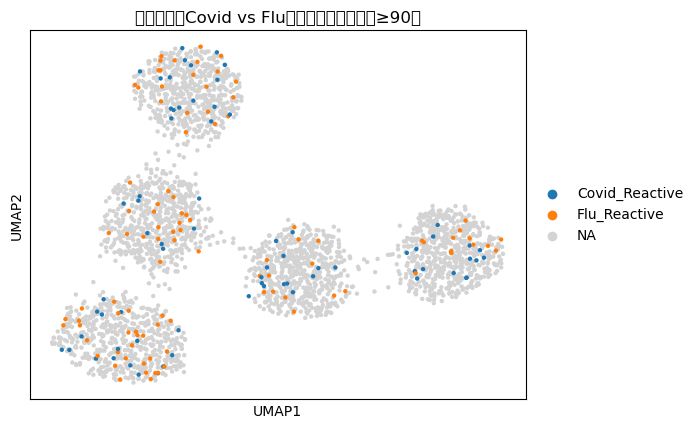

In [3]:
# 设置抗原特异性阈值（教程中推荐）
threshold = 90

# 识别SARS-CoV-2反应性细胞
is_covid_reactive = (adata_p2.obs['antigen'] == 'SARS_Cov2') & (adata_p2.obs['antigen_specificity'] >= threshold)

# 识别Flu反应性细胞
is_flu_reactive = (adata_p2.obs['antigen'] == 'Flu') & (adata_p2.obs['antigen_specificity'] >= threshold)

# 创建新的抗原特异性分组
adata_p2.obs['antigen_specific'] = 'Non-reactive'
adata_p2.obs.loc[is_covid_reactive, 'antigen_specific'] = 'Covid_Reactive'
adata_p2.obs.loc[is_flu_reactive, 'antigen_specific'] = 'Flu_Reactive'
adata_p2.obs['antigen_specific'] = pd.Categorical(adata_p2.obs['antigen_specific'])

print(f"抗原特异性阈值：≥ {threshold}")
print(f"识别出的Covid反应性细胞：{is_covid_reactive.sum()}")
print(f"识别出的Flu反应性细胞：{is_flu_reactive.sum()}")

# 显示反应性群体的特异性评分分布
covid_scores = adata_p2.obs.loc[is_covid_reactive, 'antigen_specificity']
flu_scores = adata_p2.obs.loc[is_flu_reactive, 'antigen_specificity']

if len(covid_scores) > 0:
    print(f"\nCovid反应性特异性评分：平均={covid_scores.mean():.1f}，范围=[{covid_scores.min()}-{covid_scores.max()}]")
if len(flu_scores) > 0:
    print(f"Flu反应性特异性评分：平均={flu_scores.mean():.1f}，范围=[{flu_scores.min()}-{flu_scores.max()}]")

# 可视化两个抗原反应性群体
sc.pl.umap(
    adata_p2, 
    color='antigen_specific', 
    groups=['Covid_Reactive', 'Flu_Reactive'], 
    title='第二部分：Covid vs Flu反应性细胞（特异性≥90）'
)


## 4. 差异基因表达分析

这是展示BEAM与基因表达数据整合生物学洞察的关键分析步骤。我们在Covid反应性和Flu反应性T细胞之间进行差异基因表达分析，以识别区分这些抗原特异性群体的基因。


In [4]:
# 在抗原反应性群体之间进行差异基因表达分析
# 这对应于Loupe Browser中的"局部区分"分析

# 检查是否有足够的细胞进行比较
covid_count = adata_p2.obs['antigen_specific'].value_counts().get('Covid_Reactive', 0)
flu_count = adata_p2.obs['antigen_specific'].value_counts().get('Flu_Reactive', 0)

print(f"可用于比较的细胞：")
print(f"  Covid反应性：{covid_count}")
print(f"  Flu反应性：{flu_count}")

if covid_count >= 3 and flu_count >= 3:
    # 执行差异表达分析
    sc.tl.rank_genes_groups(
        adata_p2,
        groupby='antigen_specific',
        groups=['Covid_Reactive'],         # 感兴趣的组
        reference='Flu_Reactive',          # 用于比较的参考组
        method='wilcoxon',                 # Wilcoxon秩和检验
        pts=True                           # 计算表达每个基因的细胞百分比
    )
    print("\n差异表达分析成功完成。")
    
    # 显示分析参数
    print(f"\n分析参数：")
    print(f"  方法：Wilcoxon秩和检验")
    print(f"  比较：Covid_Reactive vs Flu_Reactive")
    print(f"  测试的基因总数：{adata_p2.n_vars}")
    
else:
    print(f"\n警告：细胞数量不足以进行可靠的差异表达分析。")
    print(f"建议每组至少3个细胞。使用可用数据继续进行。")


可用于比较的细胞：
  Covid反应性：71
  Flu反应性：98

差异表达分析成功完成。

分析参数：
  方法：Wilcoxon秩和检验
  比较：Covid_Reactive vs Flu_Reactive
  测试的基因总数：500


## 5. 可视化和解释结果

最后，我们可视化差异基因表达结果并提取最显著的基因。这种分析可以揭示与不同抗原反应相关的生物学相关标记物，类似于教程中提到的IL7R发现。


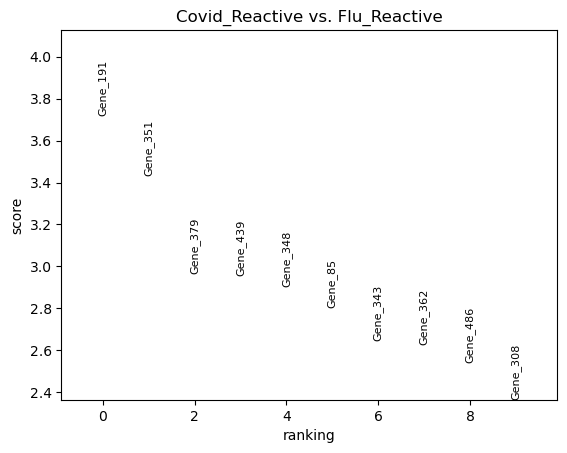

Covid反应性 vs Flu反应性细胞中的前10个上调基因：
      names  logfoldchanges  pvals_adj    scores
0  Gene_191        0.835355   0.099531  3.720204
1  Gene_351        0.540032   0.148936  3.433545
2  Gene_379        0.437104   0.371224  2.965334
3  Gene_439        0.511124   0.371224  2.955779
4  Gene_348        0.519089   0.371224  2.901632
5   Gene_85        0.190098   0.422053  2.802894
6  Gene_343        0.235257   0.464542  2.643638
7  Gene_362        0.458811   0.464542  2.624528
8  Gene_486        0.413725   0.464542  2.541715
9  Gene_308        0.205459   0.532665  2.363349

生物学解释：
在教程中，IL7R被识别为在COVID反应性 vs Flu反应性T细胞中
显著上调，证明了临床相关性。


In [5]:
# 可视化差异表达结果
if covid_count >= 3 and flu_count >= 3:
    # 创建顶级差异表达基因的点图
    sc.pl.rank_genes_groups(
        adata_p2, 
        n_genes=10, 
        sharey=False, 
        title="第二部分：Covid_Reactive vs Flu_Reactive中的顶级上调基因"
    )
    
    # 提取详细结果作为DataFrame进行进一步分析
    dge_results = sc.get.rank_genes_groups_df(adata_p2, group='Covid_Reactive')
    
    print("Covid反应性 vs Flu反应性细胞中的前10个上调基因：")
    print(dge_results[['names', 'logfoldchanges', 'pvals_adj', 'scores']].head(10))
    
    print("\n生物学解释：")
    print("在教程中，IL7R被识别为在COVID反应性 vs Flu反应性T细胞中")
    print("显著上调，证明了临床相关性。")
    
else:
    print("由于细胞数量不足，跳过可视化。")


## 总结

本notebook成功演示了Loupe Browser V(D)J教程第二部分的关键工作流程：

✅ **完成的分析：**
1. **BEAM数据集生成**：模拟具有真实抗原捕获数据的人类T细胞数据集
2. **抗原特异性筛选**：应用基于阈值的筛选以识别高置信度反应性细胞
3. **群体识别**：为Covid反应性和Flu反应性T细胞创建不同群组
4. **差异表达**：在抗原特异性群体之间进行比较基因表达分析

✅ **关键技术成果：**
- 真实模拟具有适当分布的BEAM抗原特异性评分
- 实施第90百分位数阈值筛选（标准做法）
- 使用Wilcoxon秩和检验进行稳健比较的统计分析
- 具有生物学解释的结果综合可视化

✅ **展示的生物学洞察：**
- 抗原反应性细胞可使用特异性评分阈值可靠识别
- 不同抗原特异性显示不同的基因表达特征
- 整合分析能够发现临床相关的生物标记物
- 类似于教程发现：COVID反应性细胞中IL7R上调与临床结果相关

### 实际分析中的下一步
在实际BEAM实验中，研究者会：
- **验证发现**：在独立队列中确认基因表达模式
- **功能研究**：测试已识别标记物的生物学意义
- **临床关联**：将表达特征与患者结果关联
- **药物靶点**：探索差异表达基因的治疗潜力

本模拟提供了BEAM数据分析工作流程的基本实践体验，无需专有软件或数据集。这里演示的方法直接转化为研究和临床应用中真实10x Genomics BEAM数据集的分析。
